step 1-5

In [1]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data

class Function: # only forward propagation is implemented
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        return output

def forward(self, x):
    raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        return x**2

class Exp(Function):
    def forward(self, x):
        return np.exp(x)

def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data)/(2*eps)

step 6

In [2]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None # save gradient once forward prop finished

In [3]:
class Function:
    def __call__(self, input):
        x = input.data 
        y = self.forward(x)
        output = Variable(y)
        self.input = input # save input, being used in backprop
        return output
    
    def forward(self, x): # to be implemented in each subclass that inherits Function class
        raise NotImplementedError()
        
    def backward(self, gy): #  to be implemented in each subclass that inherits Function class
        raise NotImplementedError()

In [4]:
class Square(Function): # y = x^2
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy): # toss back dy/dx = 2x
        x = self.input.data
        gx = 2 * x * gy
        return gx

In [5]:
class Exp(Function): # y = e^x
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy): # toss back dy/dx = e^x
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [36]:
# Forward prop example

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

#print(y.data)

1.648721270700128


In [37]:
# Backward prop example

y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)

# it works but let's go on automation of process (define by run)

3.297442541400256


Step 7 Automation of back prop (once forward prop is done, procedure of back prop is set automatically)

In [31]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None # variable to remember its mother

    def set_creator(self, func): # method to remember its mother
        self.creator = func

        
class Function: # Function saves its input and output
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y) # output is the son of a mother, so
        output.set_creator(self) # it remembers who is its mother via "set_creator" function
        
        self.input = input
        self.output = output
        
        return output
    
    def forward(self, x): # will be implemented in each subclass that inherits from the parent class
        raise NotImplementedError()
        
    def backward(self, gy): #  will be implemented in each subclass that inherits from the parent class
        raise NotImplementedError()
    

# In a nutshell, 
# Function saves input and ouput
# output saves Function

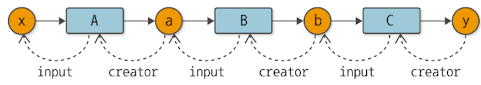

In [46]:
# Structure concept

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))

a = A(x)
b = B(a)
y = C(b)

assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x


# simple backward prop example

# calculate gradient at b from y
y.grad = np.array(1.0) # assume gradient at y = 1
C = y.creator # y knows its mother function, C
b = C.input # C knows its input, b
b.grad = C.backward(y.grad) # save gradient at b calculated from C.backward

# calculate gradient at a from b
B = b.creator
a = B.input
a.grad = B.backward(b.grad) 

# calculate gradient at x from a
A = a.creator
x = A.input
x.grad = A.backward(a.grad) 

print(x.grad)

# Still, it's somewhat repititive like B-a-a.grad, A-x-x.grad. Let's make it automatic.

3.297442541400256


In [53]:
import numpy as np


class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self): # backward function takes three steps in order
        f = self.creator  # 1. check who is the mother function
        if f is not None:
            x = f.input  # 2. mother knows which one is input
            x.grad = f.backward(self.grad)  # 3. mother is able to calculate gradient at input
            x.backward() # call another backward function until creator==None, which means input==x


In [52]:
# example

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# backprop
y.grad = np.array(1.0)
y.backward() # it backpropagates till the end, x. We get x.grad.
print(x.grad)

3.297442541400256


Step 8

In [56]:
# we called backward function recursively, backward(backward(backward()))
# This time, convert recursive function call to loop structure. why? memory efficiency

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        funcs = [self.creator] # first, put mother function in the list
        while funcs: # while loop instead of recursive function calls
            f = funcs.pop() # take out (remove from the list) and save the mother function in f
            x, y = f.input, f.output # mother knows both input and output
            x.grad = f.backward(y.grad) # calculate gradient at input with gradient at output
            
            if x.creator is not None: # if we find the mother of current input,
                funcs.append(x.creator) # put it in the list and restart the process with it

In [57]:
# example

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# backprop
y.grad = np.array(1.0)
y.backward() # it backpropagates till the end, x. We get x.grad.
print(x.grad)

3.297442541400256


Chapter 9 (make functions deployment and back prop method simple)

In [58]:
#1. rather than creating an instance and using it, we define extra functions as below:

def square(x):
    return Square()(x)

def exp(x):
    return Exp()(x)



In [59]:
# Now, we can code in simple form.

x = Variable(np.array(0.5))
a = square(x)
b = exp(a)
y = square(b)
# or even like y = square(exp(square(x)))

y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


In [60]:
#2. remove y.grad = np.array(1.0)

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None: # once backward function is called, set initial output gradient (y_grad) is set to 1(s)
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop() 
            x, y = f.input, f.output 
            x.grad = f.backward(y.grad) 
            
            if x.creator is not None: 
                funcs.append(x.creator) 

In [62]:
x = Variable(np.array(0.5)) # input
y = square(exp(square(x))) # output via forward prop
y.backward() # call backward()
print(x.grad)

3.297442541400256


In [63]:
# what if user tries to put non-ndarray data into Variable?

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop() 
            x, y = f.input, f.output 
            x.grad = f.backward(y.grad) 
            
            if x.creator is not None: 
                funcs.append(x.creator) 

In [66]:
# example

x = Variable(np.array(1.0))
x = Variable(None)

#x = Variable(1.0) # raise error

In [70]:
# but Python results in float after applying operations on 0-dimension ndarray.
# we need to deal with this issue.

# for make it easy, define a function

def as_array(x):
    if np.isscalar(x): # int and float are scalar
        return np.arrary(x)
    return x

class Function: 
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(as_array(y))
        output.set_creator(self) 
        
        self.input = input
        self.output = output
        
        return output
    
    def forward(self, x): 
        raise NotImplementedError()
        
    def backward(self, gy): 
        raise NotImplementedError()

Step 10. How to test DL framework?

In [75]:
import unittest

class SquareTest(unittest.TestCase):
    def test_forward(self): # name of method should begin with 'test'
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)
        
    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)
        
    def test_gradient_check(self):
        x = Variable(np.random.rand(1))
        y = square(x)
        y.backward()
        num_grad = numerical_diff(square, x)
        flg = np.allclose(x.grad, num_grad)
        self.assertTrue(flg)

In [73]:
# python -m unittest steps/step10.py